# Title: Leveraging AI in Combatting Fake News through Stance Detection

# Preprocessing and transformation

In [65]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, os, re, string
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [3]:
from wordcloud import WordCloud,STOPWORDS

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import drive
drive.mount('/content/drive')
import sys
train_bodies = pd.read_csv('/content/drive/MyDrive/NLPcourse/Project/train_bodies.csv')
train_stances = pd.read_csv('/content/drive/MyDrive/NLPcourse/Project/train_stances.csv')
test_bodies = pd.read_csv('/content/drive/MyDrive/NLPcourse/Project/test_bodies.csv')
test_stances = pd.read_csv('/content/drive/MyDrive/NLPcourse/Project/test_stances_unlabeled.csv')



Mounted at /content/drive


In [5]:
train_bodies.head()

Body ID                                        articleBody
0        0  A small meteorite crashed into a wooded area i...
1        4  Last week we hinted at what was to come as Ebo...
2        5  (NEWSER) – Wonder how long a Quarter Pounder w...
3        6  Posting photos of a gun-toting child online, I...
4        7  At least 25 suspected Boko Haram insurgents we...

In [6]:
train_stances.head()

Headline  Body ID     Stance
0  Police find mass graves with at least '15 bodi...      712  unrelated
1  Hundreds of Palestinians flee floods in Gaza a...      158      agree
2  Christian Bale passes on role of Steve Jobs, a...      137  unrelated
3  HBO and Apple in Talks for $15/Month Apple TV ...     1034  unrelated
4  Spider burrowed through tourist's stomach and ...     1923   disagree

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns


In [8]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
# Merge stance with bodies on 'Body ID'
train = pd.merge(train_bodies, train_stances, on='Body ID')
test = pd.merge(test_bodies, test_stances, on='Body ID')

In [10]:
train.head()

Body ID                                        articleBody  \
0        0  A small meteorite crashed into a wooded area i...   
1        0  A small meteorite crashed into a wooded area i...   
2        0  A small meteorite crashed into a wooded area i...   
3        0  A small meteorite crashed into a wooded area i...   
4        0  A small meteorite crashed into a wooded area i...   

                                            Headline     Stance  
0  Soldier shot, Parliament locked down after gun...  unrelated  
1  Tourist dubbed ‘Spider Man’ after spider burro...  unrelated  
2  Luke Somers 'killed in failed rescue attempt i...  unrelated  
3   BREAKING: Soldier shot at War Memorial in Ottawa  unrelated  
4  Giant 8ft 9in catfish weighing 19 stone caught...  unrelated

In [ ]:
test.head()

In [ ]:
train.isna().sum()

Body ID        0
articleBody    0
Headline       0
Stance         0
dtype: int64

In [ ]:
test.isna().sum()

In [13]:
# Function to preprocess text: remove stopwords, punctuation, and quotation marks
def preprocess_text(text):
    stopword = set(stopwords.words('english'))
    # Remove punctuation, quotation marks, and stopwords
    cleaned_text = ''.join([char for char in text if char not in string.punctuation and char != "'"])
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word.lower() not in stopword])
    return cleaned_text

# Apply preprocessing to the Headline and Body columns
train['cleaned_headline'] = train.Headline.apply(lambda x: preprocess_text(x))
train['cleaned_body'] = train.articleBody.apply(lambda x: preprocess_text(x))



In [14]:
train.head()

Body ID                                        articleBody  \
0        0  A small meteorite crashed into a wooded area i...   
1        0  A small meteorite crashed into a wooded area i...   
2        0  A small meteorite crashed into a wooded area i...   
3        0  A small meteorite crashed into a wooded area i...   
4        0  A small meteorite crashed into a wooded area i...   

                                            Headline     Stance  \
0  Soldier shot, Parliament locked down after gun...  unrelated   
1  Tourist dubbed ‘Spider Man’ after spider burro...  unrelated   
2  Luke Somers 'killed in failed rescue attempt i...  unrelated   
3   BREAKING: Soldier shot at War Memorial in Ottawa  unrelated   
4  Giant 8ft 9in catfish weighing 19 stone caught...  unrelated   

                                    cleaned_headline  \
0  Soldier shot Parliament locked gunfire erupts ...   
1  Tourist dubbed ‘Spider Man’ spider burrows ski...   
2     Luke Somers killed failed rescue attempt Yemen   
3          BREAKING Soldier shot War Memorial Ottawa   
4  Giant 8ft 9in catfish weighing 19 stone caught...   

                                        cleaned_body  
0  small meteorite crashed wooded area Nicaraguas...  
1  small meteorite crashed wooded area Nicaraguas...  
2  small meteorite crashed wooded area Nicaraguas...  
3  small meteorite crashed wooded area Nicaraguas...  
4  small meteorite crashed wooded area Nicaraguas...

# Feature engineering

In [19]:
## For Headline
### A. TOTAL NUMBER OF WORDS USED
train['headline_nb_words'] = train.cleaned_headline.apply(lambda x: len(x.split()))
### B. TOTAL NUMBER OF UNIQUE WORDS USED
train['headline_nb_unique_words'] = train.cleaned_headline.apply(lambda x: len(set(x.split())))
### C. TOTAL NUMBER OF CHARACTERS USED
train['headline_nb_char'] = train.cleaned_headline.apply(lambda x: len(x))

## For Body
### A. TOTAL NUMBER OF WORDS USED
train['body_nb_words'] = train.cleaned_body.apply(lambda x: len(x.split()))
### B. TOTAL NUMBER OF UNIQUE WORDS USED
train['body_nb_unique_words'] = train.cleaned_body.apply(lambda x: len(set(x.split())))
### C. TOTAL NUMBER OF CHARACTERS USED
train['body_nb_char'] = train.cleaned_body.apply(lambda x: len(x))


# Display the first few rows of the train dataset
train.head()

Body ID                                        articleBody  \
0        0  A small meteorite crashed into a wooded area i...   
1        0  A small meteorite crashed into a wooded area i...   
2        0  A small meteorite crashed into a wooded area i...   
3        0  A small meteorite crashed into a wooded area i...   
4        0  A small meteorite crashed into a wooded area i...   

                                            Headline     Stance  \
0  Soldier shot, Parliament locked down after gun...  unrelated   
1  Tourist dubbed ‘Spider Man’ after spider burro...  unrelated   
2  Luke Somers 'killed in failed rescue attempt i...  unrelated   
3   BREAKING: Soldier shot at War Memorial in Ottawa  unrelated   
4  Giant 8ft 9in catfish weighing 19 stone caught...  unrelated   

                                    cleaned_headline  \
0  Soldier shot Parliament locked gunfire erupts ...   
1  Tourist dubbed ‘Spider Man’ spider burrows ski...   
2     Luke Somers killed failed rescue attempt Yemen   
3          BREAKING Soldier shot War Memorial Ottawa   
4  Giant 8ft 9in catfish weighing 19 stone caught...   

                                        cleaned_body  headline_nb_words  \
0  small meteorite crashed wooded area Nicaraguas...                  8   
1  small meteorite crashed wooded area Nicaraguas...                  8   
2  small meteorite crashed wooded area Nicaraguas...                  7   
3  small meteorite crashed wooded area Nicaraguas...                  6   
4  small meteorite crashed wooded area Nicaraguas...                 15   

   headline_nb_unique_words  headline_nb_char  body_nb_words  \
0                         8                58            181   
1                         8                52            181   
2                         7                46            181   
3                         6                41            181   
4                        15                89            181   

   body_nb_unique_words  body_nb_char  
0                   136          1357  
1                   136          1357  
2                   136          1357  
3                   136          1357  
4                   136          1357

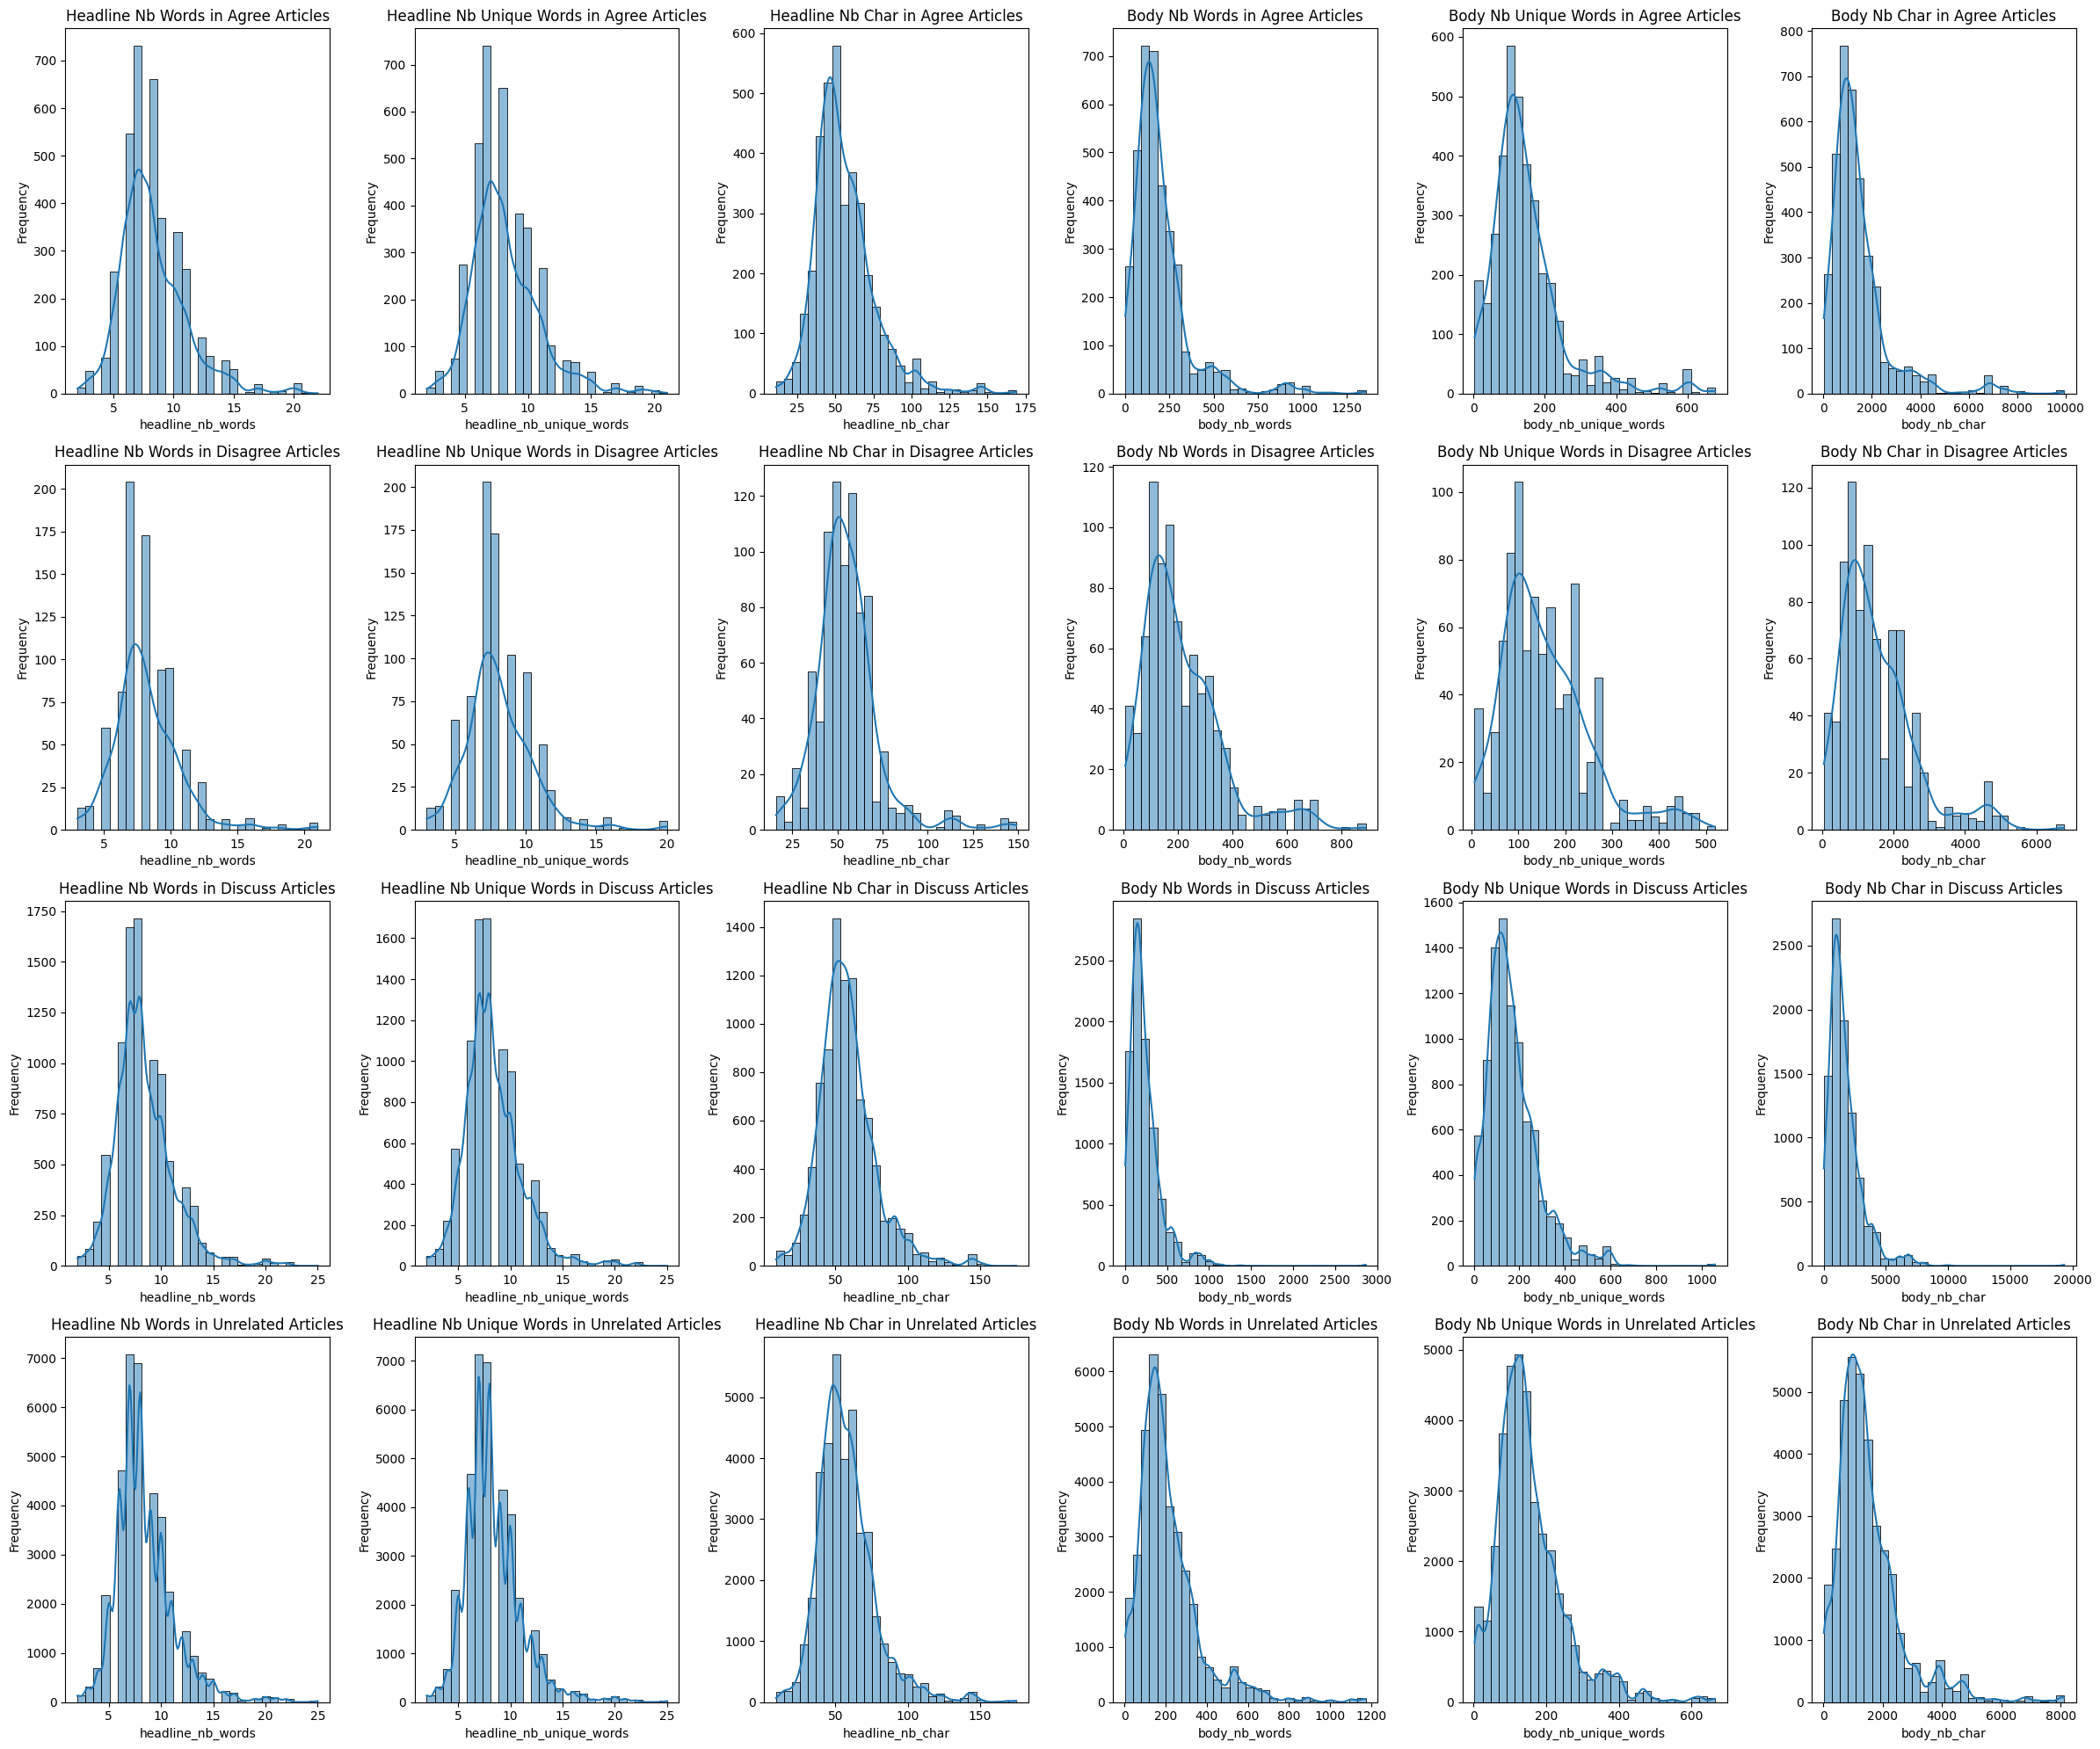


Descriptive Statistics for Headline Nb Words:

Agree Articles:
count    3678.000000
mean        8.235998
std         2.728448
min         2.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        22.000000
Name: headline_nb_words, dtype: float64

Disagree Articles:
count    840.000000
mean       8.138095
std        2.467423
min        3.000000
25%        7.000000
50%        8.000000
75%        9.000000
max       21.000000
Name: headline_nb_words, dtype: float64

Discuss Articles:
count    8909.000000
mean        8.381973
std         2.756735
min         2.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        25.000000
Name: headline_nb_words, dtype: float64

Unrelated Articles:
count    36545.000000
mean         8.440690
std          2.796591
min          2.000000
25%          7.000000
50%          8.000000
75%         10.000000
max         25.000000
Name: headline_nb_words, dtype: float64

Descriptive Statistics for Headline Nb Uniq

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming your train data is already loaded and it's named 'train'
# train = pd.read_csv('your_train_data.csv')

# Define the different stances
stances = ['agree', 'disagree', 'discuss', 'unrelated']

# Initialize a large figure to accommodate subplots
plt.figure(figsize=(24, 20))

# Features to visualize
features = ['headline_nb_words', 'headline_nb_unique_words', 'headline_nb_char',
            'body_nb_words', 'body_nb_unique_words', 'body_nb_char']

# Loop through stances to generate plots for each feature
for i, stance in enumerate(stances):
    df_stance = train[train['Stance'] == stance]

    # Loop through each feature
    for j, feature in enumerate(features):
        # Create histogram for each feature
        plt.subplot(4, len(features), i * len(features) + j + 1)
        sns.histplot(df_stance[feature], bins=30, kde=True)
        plt.title(f'{feature.replace("_", " ").title()} in {stance.title()} Articles')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print descriptive statistics for each feature for each stance
for feature in features:
    print(f"\nDescriptive Statistics for {feature.replace('_', ' ').title()}:")
    for stance in stances:
        df_stance = train[train['Stance'] == stance]
        print(f"\n{stance.title()} Articles:")
        print(df_stance[feature].describe())


# Exploratory Data Analysis

In [ ]:
print("\nDistribution of labels:")
print(train['Stance'].value_counts())


Distribution of labels:
unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64


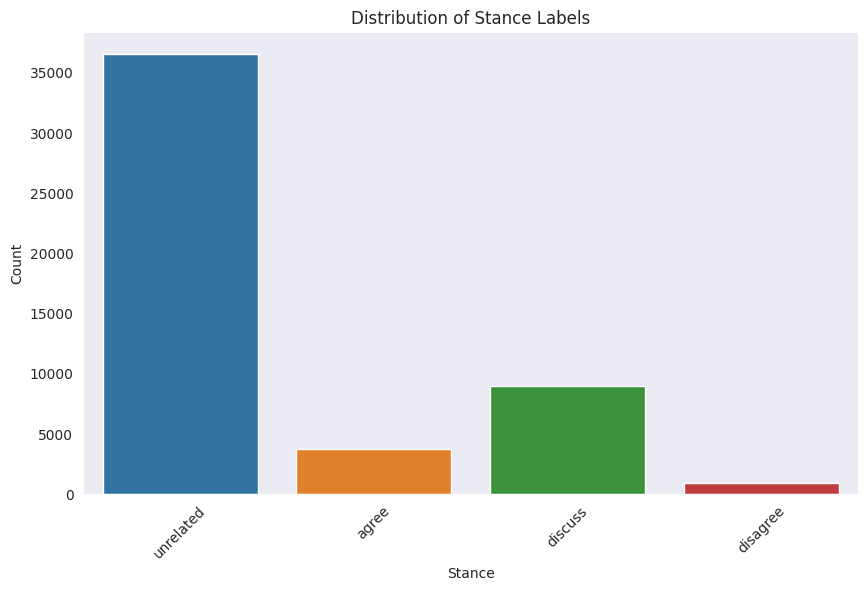

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your train data is already loaded and it's named 'train'
# train = pd.read_csv('your_train_data.csv')

sns.set_style("dark")
plt.figure(figsize=(10,6))  # You can adjust the size as per your need

# Assuming the stance labels are stored in a column named 'Stance' in your 'train' dataset
sns.countplot(x='Stance', data=train)

plt.title('Distribution of Stance Labels')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotates the stance labels on x-axis for better readability
plt.show()


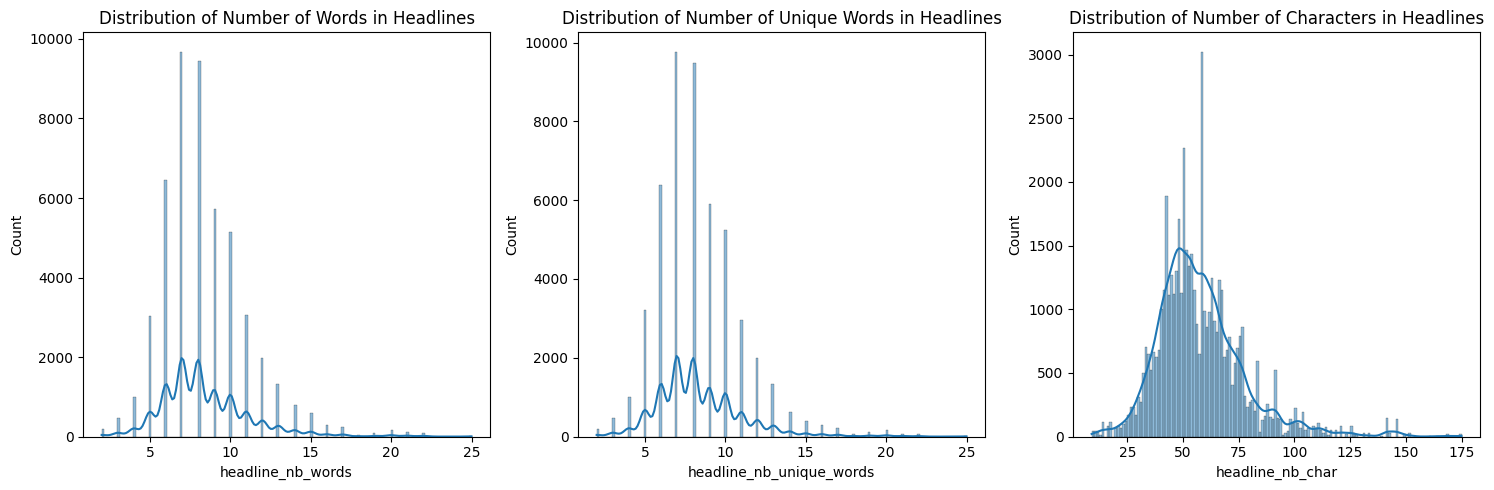

In [21]:
# 1. Visualize the distribution of the numerical features.
plt.figure(figsize=(15, 5))

# Histograms for headline-related features
plt.subplot(1, 3, 1)
sns.histplot(train['headline_nb_words'], kde=True)
plt.title('Distribution of Number of Words in Headlines')

plt.subplot(1, 3, 2)
sns.histplot(train['headline_nb_unique_words'], kde=True)
plt.title('Distribution of Number of Unique Words in Headlines')

plt.subplot(1, 3, 3)
sns.histplot(train['headline_nb_char'], kde=True)
plt.title('Distribution of Number of Characters in Headlines')

plt.tight_layout()
plt.show()

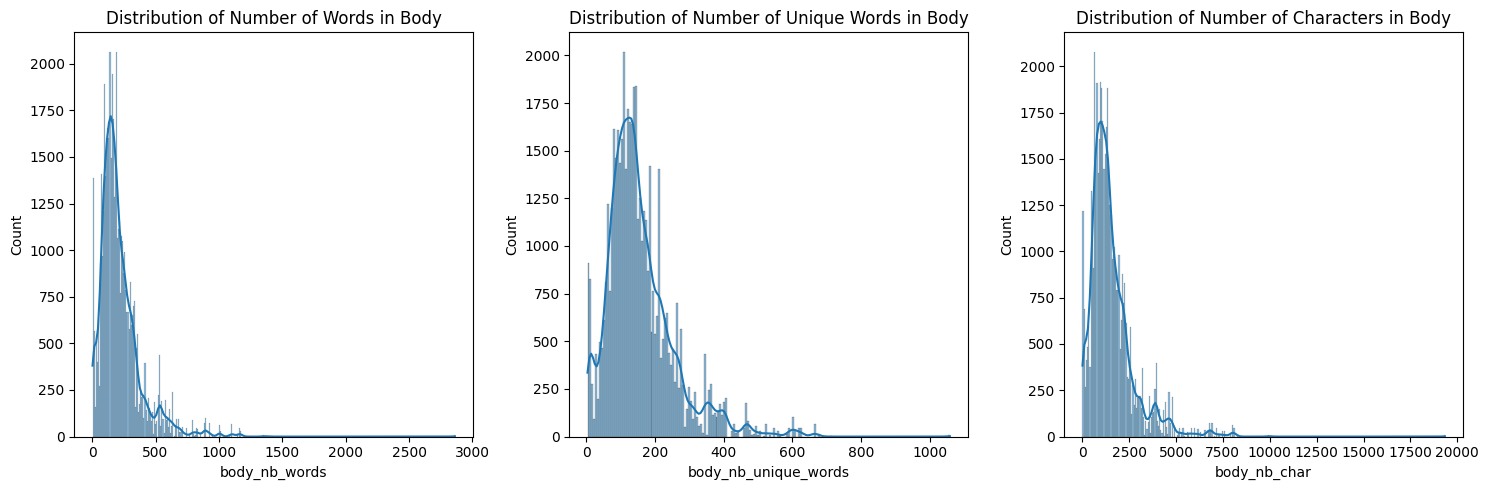

In [23]:

# Histograms for body-related features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(train['body_nb_words'], kde=True)
plt.title('Distribution of Number of Words in Body')

plt.subplot(1, 3, 2)
sns.histplot(train['body_nb_unique_words'], kde=True)
plt.title('Distribution of Number of Unique Words in Body')

plt.subplot(1, 3, 3)
sns.histplot(train['body_nb_char'], kde=True)
plt.title('Distribution of Number of Characters in Body')

plt.tight_layout()
plt.show()

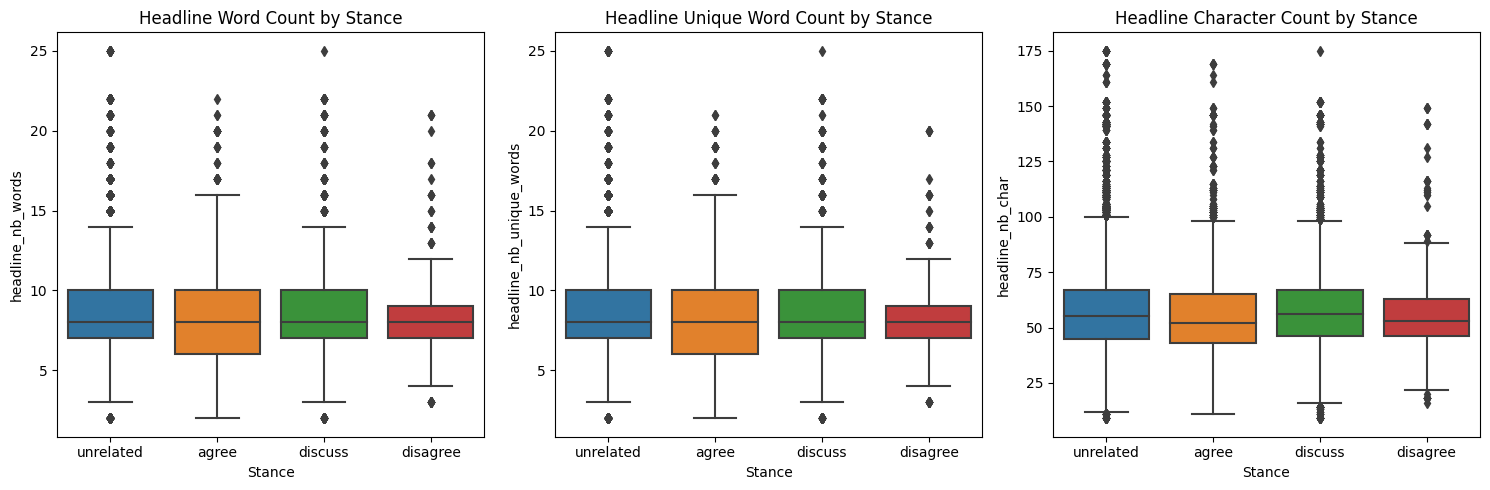

In [25]:
# 2. Compare the distribution of these features across different stances.
# Box plots for headline-related features by stance
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Stance', y='headline_nb_words', data=train)
plt.title('Headline Word Count by Stance')

plt.subplot(1, 3, 2)
sns.boxplot(x='Stance', y='headline_nb_unique_words', data=train)
plt.title('Headline Unique Word Count by Stance')

plt.subplot(1, 3, 3)
sns.boxplot(x='Stance', y='headline_nb_char', data=train)
plt.title('Headline Character Count by Stance')

plt.tight_layout()
plt.show()

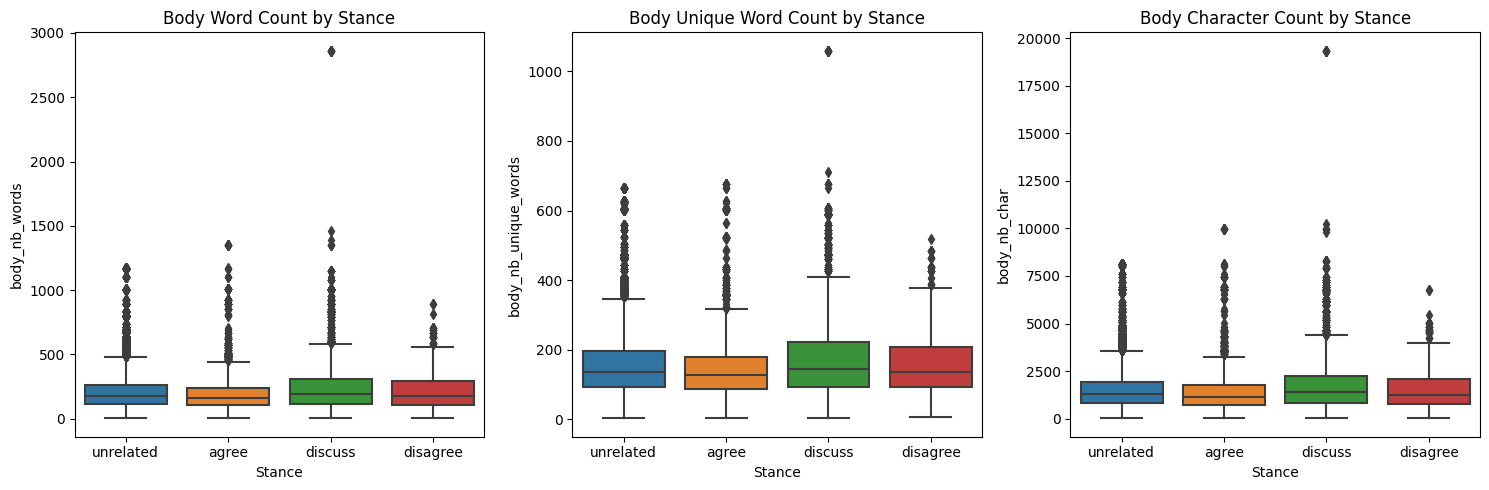

In [24]:
# Box plots for body-related features by stance
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Stance', y='body_nb_words', data=train)
plt.title('Body Word Count by Stance')

plt.subplot(1, 3, 2)
sns.boxplot(x='Stance', y='body_nb_unique_words', data=train)
plt.title('Body Unique Word Count by Stance')

plt.subplot(1, 3, 3)
sns.boxplot(x='Stance', y='body_nb_char', data=train)
plt.title('Body Character Count by Stance')

plt.tight_layout()
plt.show()


In [26]:
# Summary statistics for body-related features
print(train[['body_nb_words', 'body_nb_unique_words', 'body_nb_char']].describe())


       body_nb_words  body_nb_unique_words  body_nb_char
count   49972.000000          49972.000000  49972.000000
mean      215.789842            157.344533   1554.480749
std       163.710803             99.921449   1190.047012
min         3.000000              3.000000     16.000000
25%       116.000000             93.000000    811.000000
50%       177.000000            137.000000   1285.000000
75%       270.000000            199.000000   1955.000000
max      2862.000000           1059.000000  19336.000000


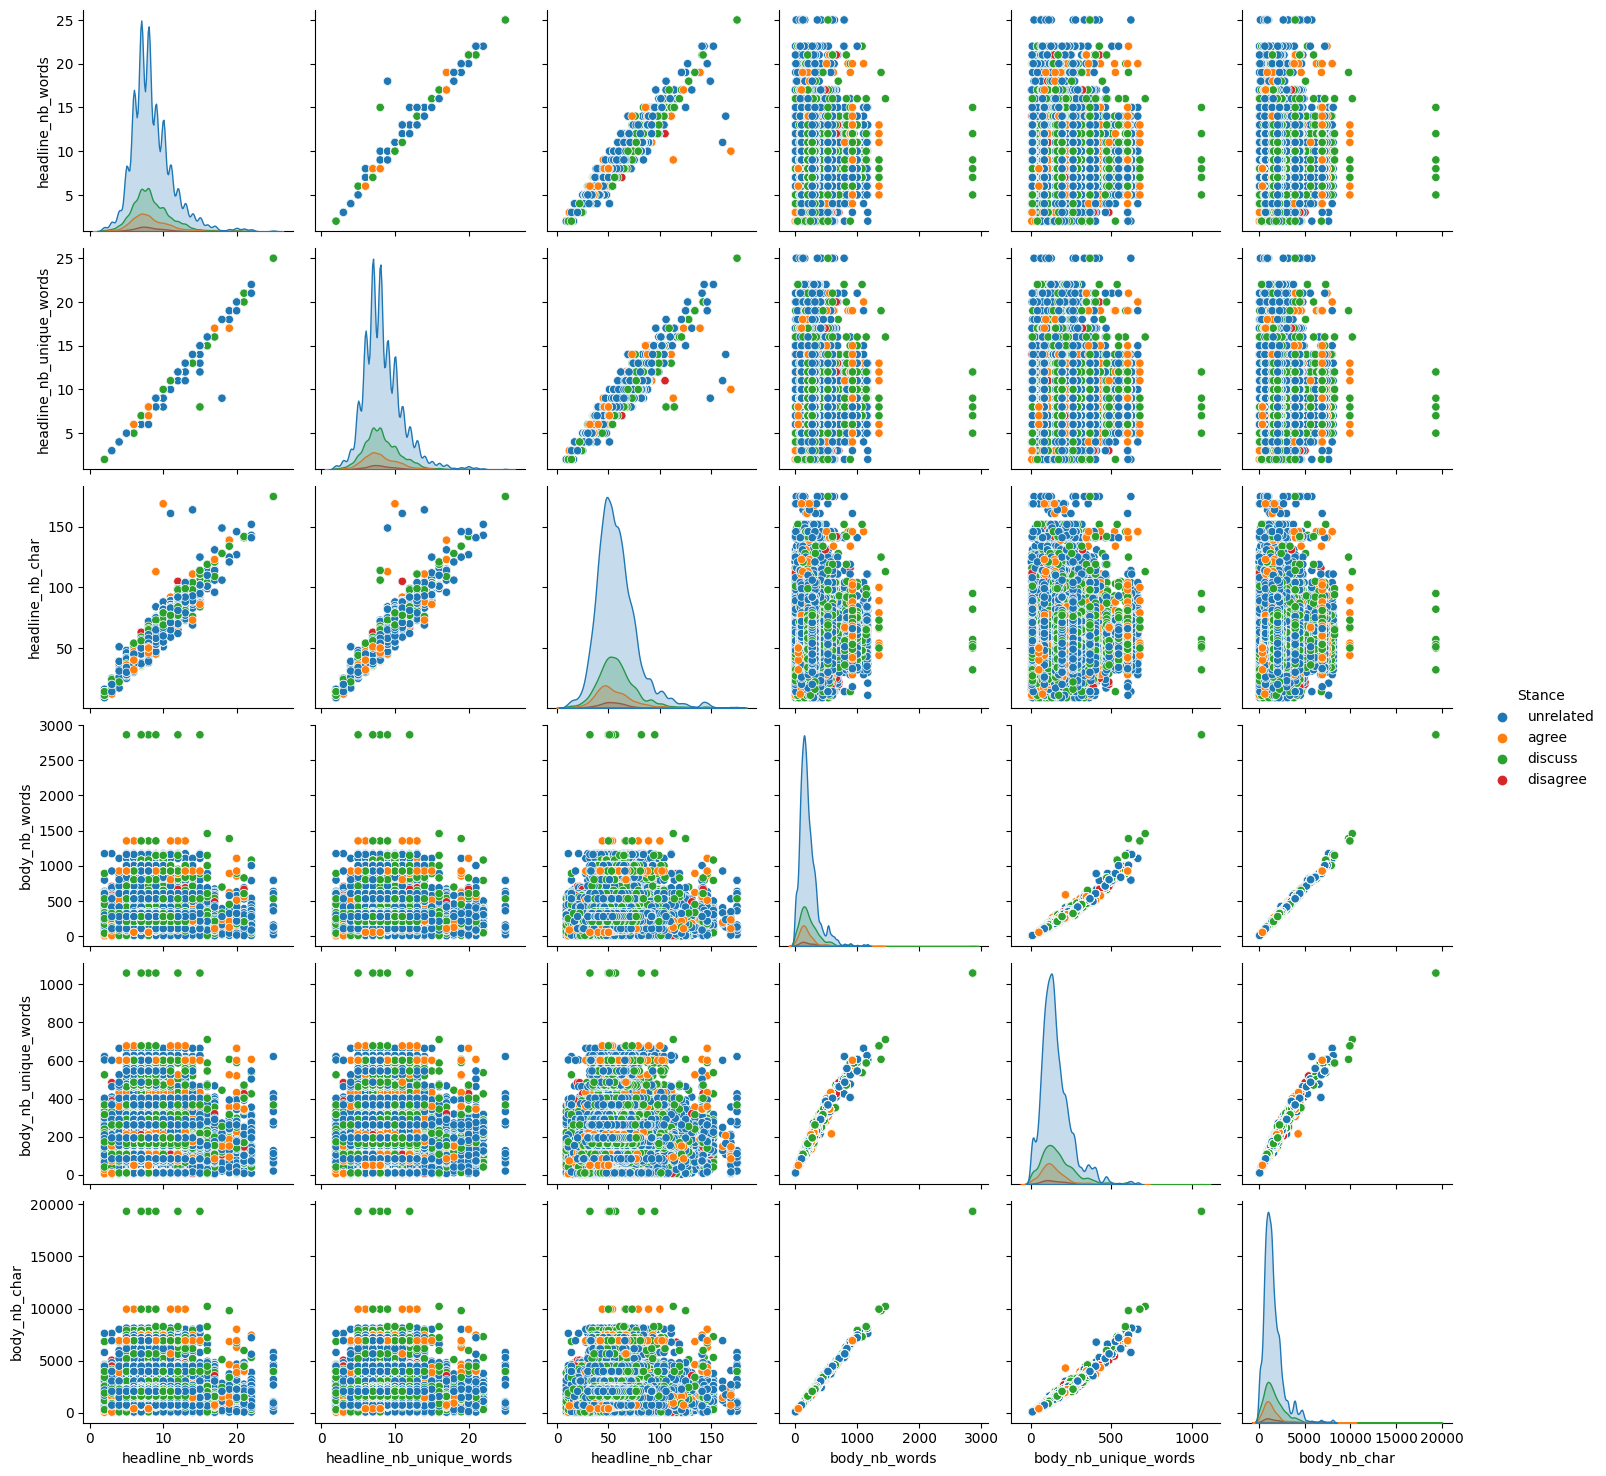

In [27]:
# Pairwise scatter plots for headline and body features
# This can be very useful to see how these features relate to each other within each stance
sns.pairplot(train, vars=['headline_nb_words', 'headline_nb_unique_words', 'headline_nb_char',
                          'body_nb_words', 'body_nb_unique_words', 'body_nb_char'], hue='Stance')
plt.show()


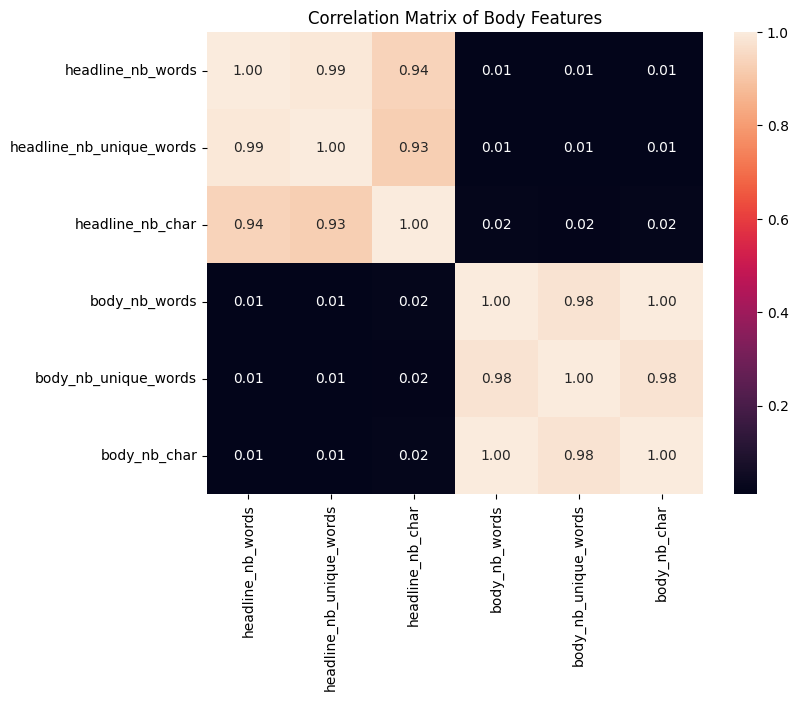

In [29]:
# Correlation matrix for body features
correlation_matrix_body = train[['headline_nb_words', 'headline_nb_unique_words', 'headline_nb_char',
                          'body_nb_words', 'body_nb_unique_words', 'body_nb_char']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_body, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Body Features')
plt.show()

# Plotting Wordcloud

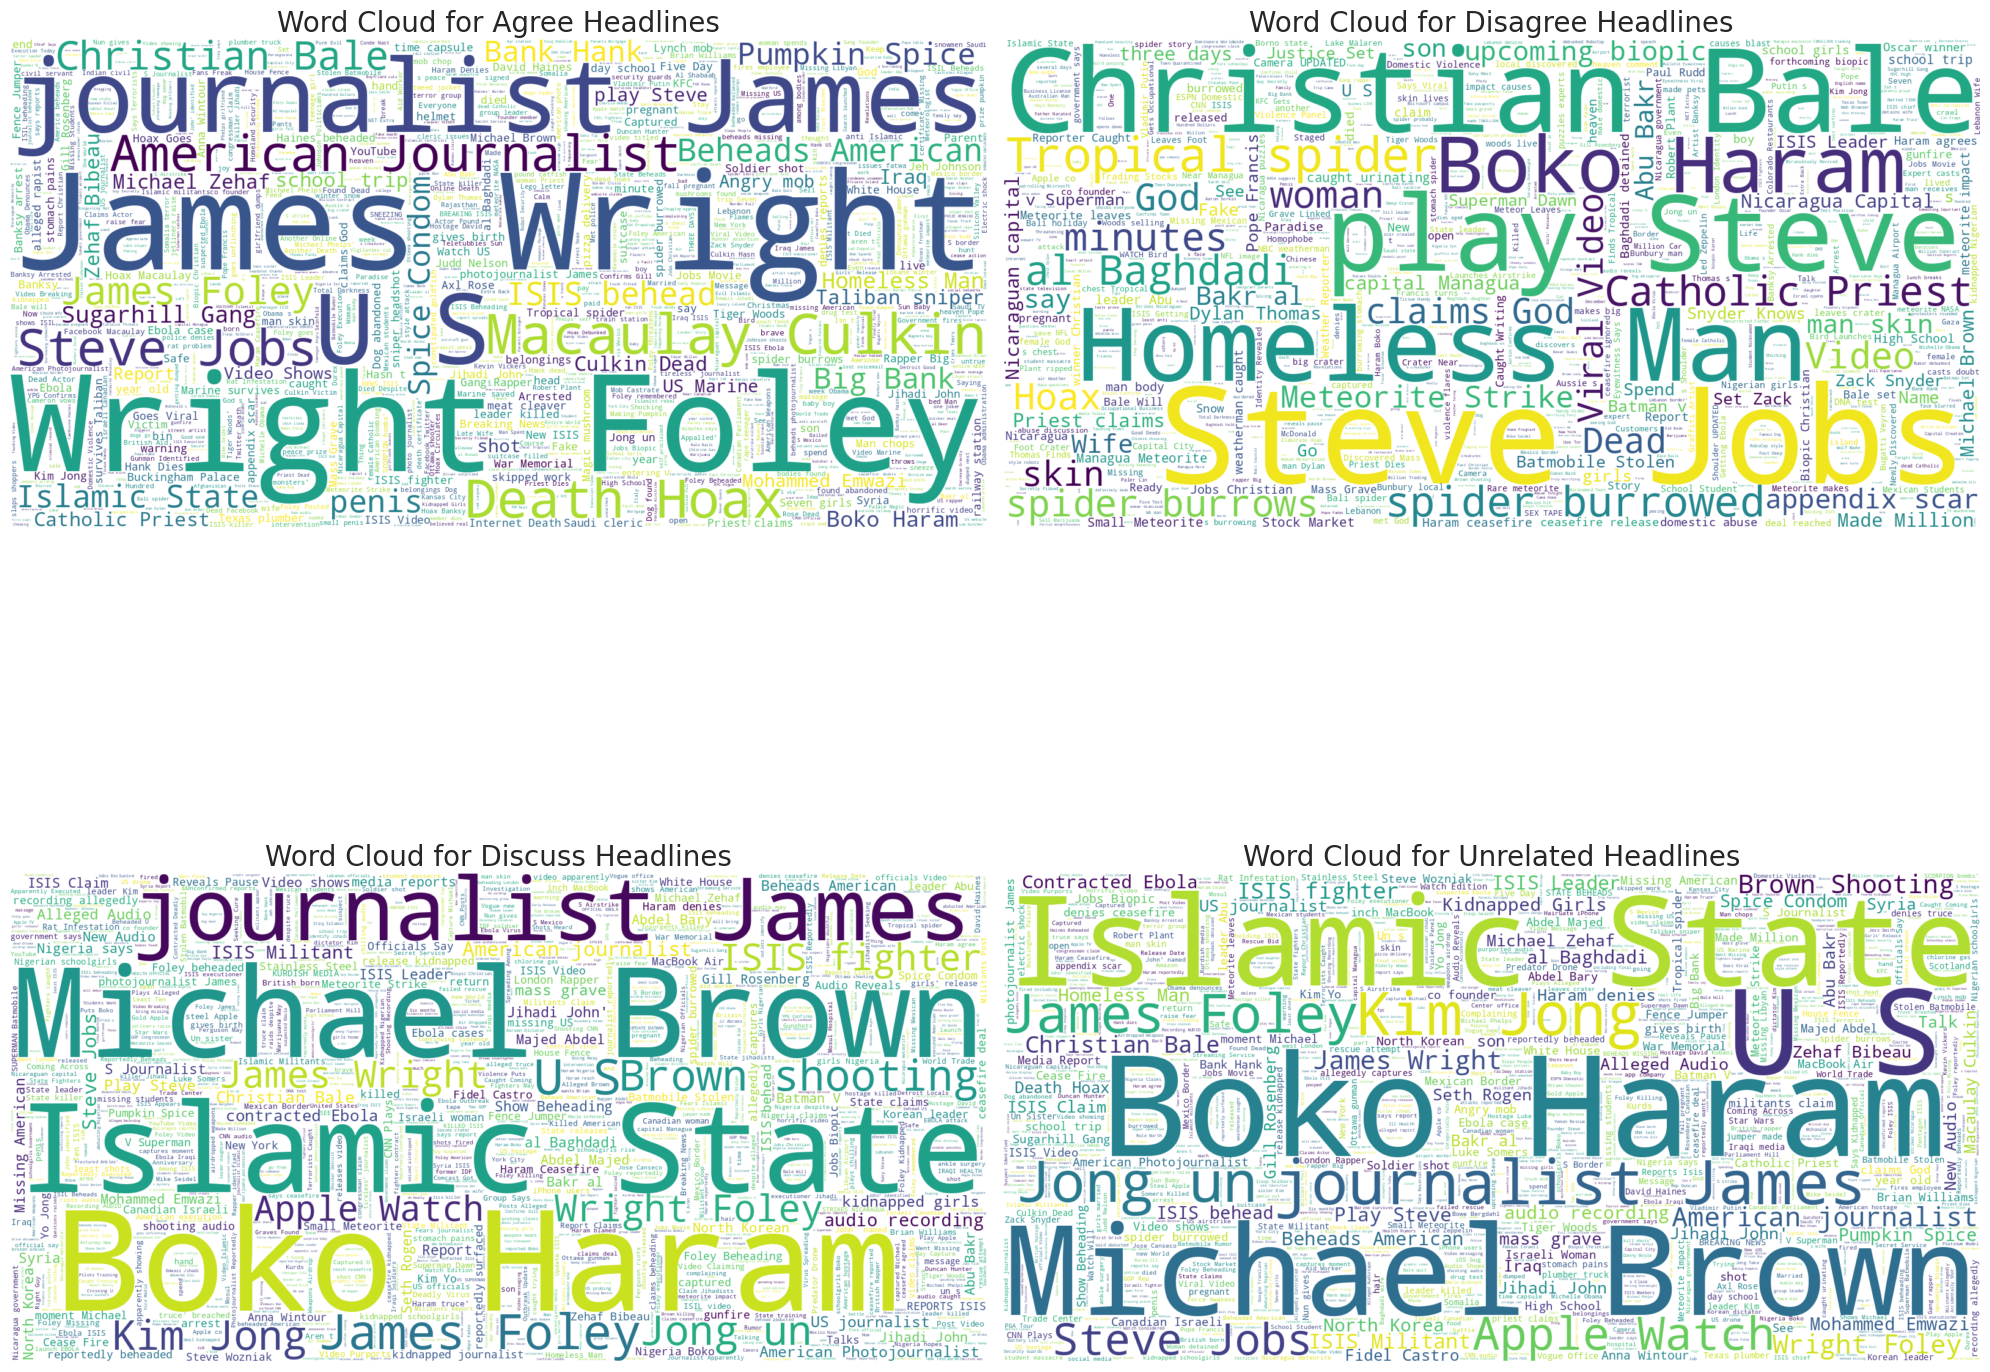

In [ ]:
stances = ['agree', 'disagree', 'discuss', 'unrelated']

# Create a figure to display the word clouds
plt.figure(figsize=(20, 20))

for i, stance in enumerate(stances):
    plt.subplot(2, 2, i+1)  # arrange the plots in 2 rows and 2 columns

    # Filter headlines based on stance
    stance_headlines = train[train['Stance'] == stance]['Headline']

    # Generate and plot word cloud
    wc = WordCloud(max_words=1000, width=1600, height=800, background_color='white').generate(" ".join(stance_headlines))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {stance.title()} Headlines', fontsize=20)
    plt.axis("off")  # to hide the axis

plt.tight_layout()
plt.show()

# Implementing Embedding Layer

## Data Processing

In [30]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Embedding, Input,LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# Subset the DataFrame
train = train_subset = train[['Body ID', 'articleBody', 'Headline', 'Stance']]
# Subset the DataFrame without the 'Stance' column
test = test_subset = test[['Body ID', 'articleBody', 'Headline']]
train['Stance'].unique()

array(['unrelated', 'agree', 'discuss', 'disagree'], dtype=object)

In [32]:
# Define a mapping from string labels to numerical labels
stance_mapping = {
    'agree': 0,
    'disagree': 1,
    'discuss': 2,
    'unrelated': 3
}

# Apply the mapping to the 'Stance' column
train['Stance'] = train['Stance'].apply(lambda x: stance_mapping[x])

# Display the first few rows of the DataFrame to verify the changes
train.head()

Body ID                                        articleBody  \
0        0  A small meteorite crashed into a wooded area i...   
1        0  A small meteorite crashed into a wooded area i...   
2        0  A small meteorite crashed into a wooded area i...   
3        0  A small meteorite crashed into a wooded area i...   
4        0  A small meteorite crashed into a wooded area i...   

                                            Headline  Stance  
0  Soldier shot, Parliament locked down after gun...       3  
1  Tourist dubbed ‘Spider Man’ after spider burro...       3  
2  Luke Somers 'killed in failed rescue attempt i...       3  
3   BREAKING: Soldier shot at War Memorial in Ottawa       3  
4  Giant 8ft 9in catfish weighing 19 stone caught...       3

In [33]:
# Combine the article body and headline into a single text column
train['combined_text'] = train['Headline'] + " " + train['articleBody']

# Now we can delete the original headline and article body columns
cols_to_delete = ['Headline', 'articleBody']
train = train.drop(cols_to_delete, axis=1)

# Display the first few entries of the updated dataframe to ensure changes are correct
train.head()

Body ID  Stance                                      combined_text
0        0       3  Soldier shot, Parliament locked down after gun...
1        0       3  Tourist dubbed ‘Spider Man’ after spider burro...
2        0       3  Luke Somers 'killed in failed rescue attempt i...
3        0       3  BREAKING: Soldier shot at War Memorial in Otta...
4        0       3  Giant 8ft 9in catfish weighing 19 stone caught...

In [34]:
# Combine the article body and headline into a single text column for test set if needed
test['combined_text'] = test['Headline'] + " " + test['articleBody']

# Now we can delete the original headline and article body columns
test = test.drop(cols_to_delete, axis=1)

# Display the first few entries of the updated dataframe to ensure changes are correct
test.head()


Body ID                                      combined_text
0        1  Apple installing safes in-store to protect gol...
1        1  El-Sisi denies claims he'll give Sinai land to...
2        1  Apple to keep gold Watch Editions in special i...
3        1  Apple Stores to Keep Gold “Edition” Apple Watc...
4        1  South Korean woman's hair 'eaten' by robot vac...

In [35]:
import re
from nltk.corpus import stopwords
import nltk

# Get the English stopwords
stop_words = stopwords.words('english')

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Remove non-alphabetic characters
    text = re.sub('[^a-z]', ' ', text)
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    return text

# Apply the cleaning function to the combined text
train['cleaned_text'] = train['combined_text'].apply(clean_text)
test['cleaned_text'] = test['combined_text'].apply(clean_text)

# Display the first few entries of the updated dataframe to ensure changes are correct
train[['Body ID', 'Stance', 'cleaned_text']].head()


Body ID  Stance                                       cleaned_text
0        0       3  soldier shot parliament locked gunfire erupts ...
1        0       3  tourist dubbed spider man spider burrows skin ...
2        0       3  luke somers killed failed rescue attempt yemen...
3        0       3  breaking soldier shot war memorial ottawa smal...
4        0       3  giant ft in catfish weighing stone caught ital...

In [36]:
# Separate the labels and the data
y = train['Stance'].values
X_text = train['cleaned_text'].values  # this is going to be a list of texts

## Tokenization and Padding

In [37]:
# Configuration settings
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [38]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_text)
sequences = tokenizer.texts_to_sequences(X_text)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [39]:
# Path to the pre-trained embedding files
glove_file_path = '/content/drive/MyDrive/NLPcourse/Project/glove.6B.50d.txt'
FASTTEXT_FILE = '/content/drive/MyDrive/NLPcourse/Project/wiki-news-300d-1M.vec'
WORD2VEC_FILE = '/content/drive/MyDrive/NLPcourseProject/GoogleNews-vectors-negative300.bin'

## Glove

In [40]:
from gensim.models import KeyedVectors
import numpy as np

# Load GloVe vectors
def load_glove_model(glove_file_path):
    print("Loading GloVe Model")
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    print("Done. {} words loaded!".format(len(glove_model)))
    return glove_model

glove_path = '/content/drive/MyDrive/NLPcourse/Project/glove.6B.100d.txt'
glove_embeddings = load_glove_model(glove_path)

Loading GloVe Model
Done. 400000 words loaded!


## FastText

In [41]:
# Load FastText vectors
def load_fasttext_model(fasttext_file_path):
    print("Loading FastText Model")
    fasttext_model = KeyedVectors.load_word2vec_format(fasttext_file_path, binary=False)
    print("Done. {} words loaded!".format(len(fasttext_model.key_to_index)))
    return fasttext_model

fasttext_path = '/content/drive/MyDrive/NLPcourse/Project/wiki-news-300d-1M.vec'
fasttext_embeddings = load_fasttext_model(fasttext_path)

Loading FastText Model
Done. 999994 words loaded!


## Word2Vec

In [42]:
# Load Word2Vec vectors
def load_word2vec_model(word2vec_file_path):
    print("Loading Word2Vec Model")
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)
    print("Done. {} words loaded!".format(len(word2vec_model.key_to_index)))
    return word2vec_model

word2vec_path = '/content/drive/MyDrive/NLPcourse/Project/GoogleNews-vectors-negative300.bin'
word2vec_embeddings = load_word2vec_model(word2vec_path)

Loading Word2Vec Model
Done. 3000000 words loaded!


# Evaluate the embedding method


### Qualititive evaluation

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity
def find_closest_embeddings(embedding, reference_word):
    if reference_word not in embedding:
        raise ValueError(f"The word '{reference_word}' is not in the embedding.")
    reference_embedding = embedding[reference_word].reshape(1, -1)
    closest_words = sorted(embedding.keys(), key=lambda word: -cosine_similarity(embedding[word].reshape(1, -1), reference_embedding)[0])
    return closest_words

# Ensure 'islamic' is in the dictionary
if 'islamic' in glove_embeddings:
    closest_words_glove = find_closest_embeddings(glove_embeddings, 'islamic')[:10]
    print("Closest words to 'islamic' in GloVe:", closest_words_glove)
else:
    print("'islamic' is not in the GloVe embeddings dictionary.")

Closest words to 'islamic' in GloVe: ['islamic', 'muslim', 'fundamentalist', 'islamist', 'militant', 'religious', 'extremist', 'islam', 'secular', 'fundamentalists']


In [44]:


# For gensim's KeyedVectors, use the built-in most_similar function
closest_words_fasttext = fasttext_embeddings.most_similar('islamic', topn=10)
print("Closest words to 'islamic' in FastText:", closest_words_fasttext)

closest_words_word2vec = word2vec_embeddings.most_similar('islamic', topn=10)
print("Closest words to 'islamic' in Word2Vec:", closest_words_word2vec)


Closest words to 'islamic' in FastText: [('muslim', 0.8157998323440552), ('Islamic', 0.7642589211463928), ('moslem', 0.7485353350639343), ('islam', 0.7440544366836548), ('islamist', 0.7432875633239746), ('non-islamic', 0.7352350354194641), ('arab', 0.7249584794044495), ('wahhabi', 0.7119608521461487), ('Isalmic', 0.7059776186943054), ('non-Islamic', 0.7005672454833984)]
Closest words to 'islamic' in Word2Vec: [('muslim', 0.7151464223861694), ('islam', 0.6959547400474548), ('muslims', 0.6580280661582947), ('Islamic', 0.6335048079490662), ('radical_islam', 0.5932999849319458), ('christianity', 0.5896561741828918), ('saudi_arabia', 0.5890650153160095), ('moslem', 0.5863087773323059), ('islamist', 0.5733752846717834), ('christian', 0.5701733827590942)]


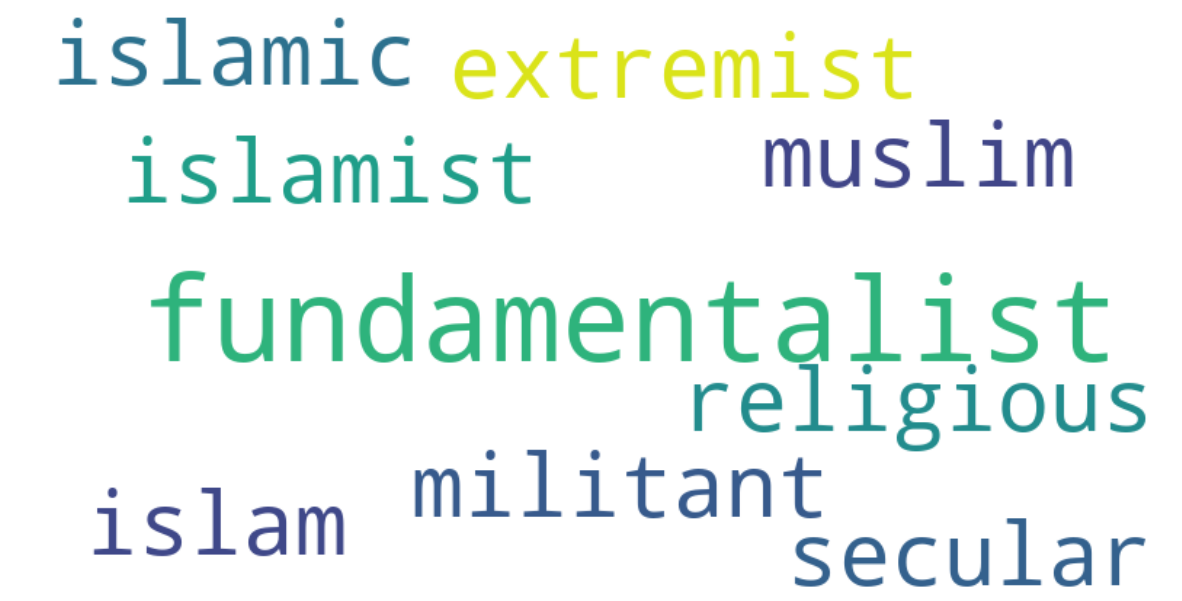

In [45]:
# Generate a word cloud using the list of closest words from GloVe embeddings
wordcloud_glove = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(closest_words_glove[:10]))

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_glove, interpolation='bilinear')
plt.axis('off')
plt.show()




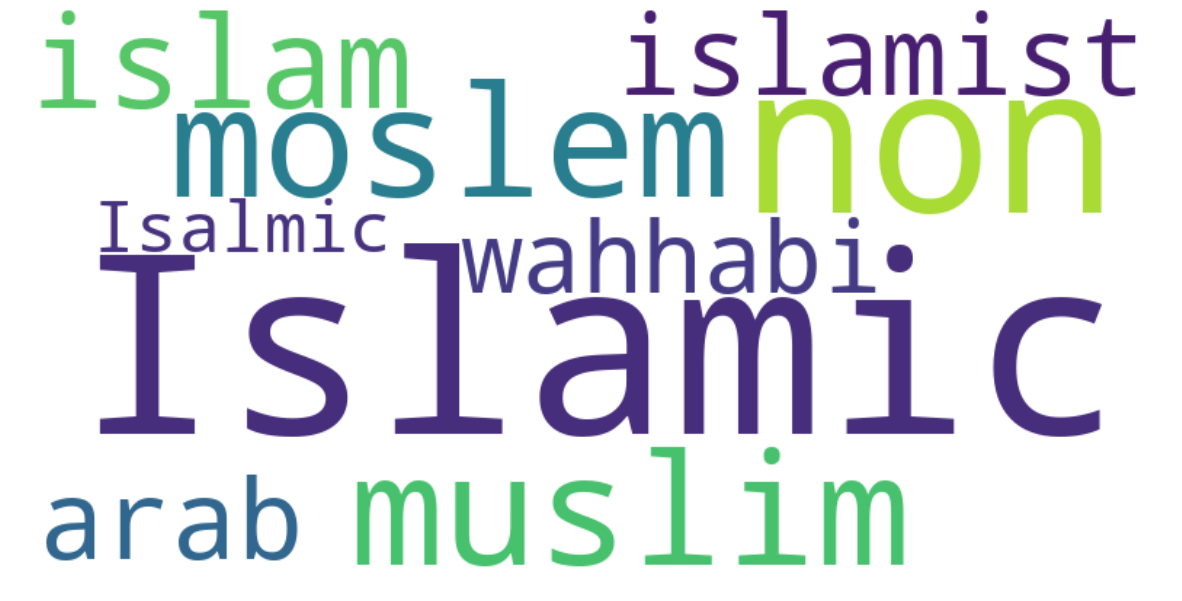

In [46]:
# Generate a word cloud using the list of closest words from FastText embeddings
wordcloud_fasttext = WordCloud(width=800, height=400, background_color ='white').generate(' '.join([word for word, _ in closest_words_fasttext]))

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_fasttext, interpolation='bilinear')
plt.axis('off')
plt.show()

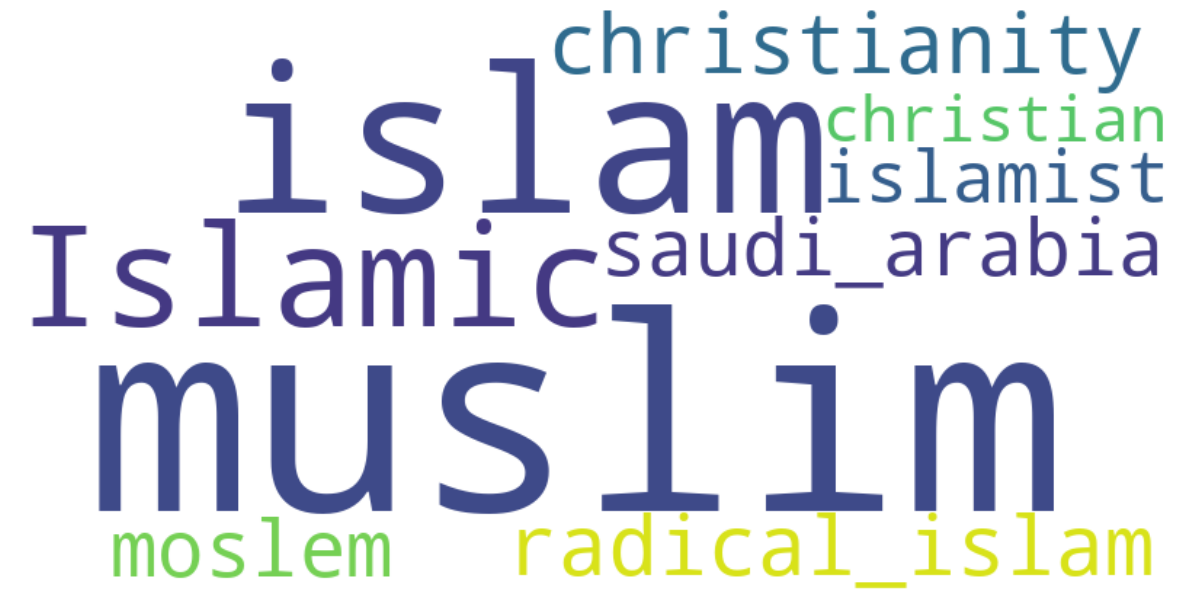

In [47]:
# Generate a word cloud using the list of closest words from Word2Vec embeddings
wordcloud_word2vec = WordCloud(width=800, height=400, background_color ='white').generate(' '.join([word for word, _ in closest_words_word2vec]))

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_word2vec, interpolation='bilinear')
plt.axis('off')
plt.show()


### Quantitaiive evaluation

In [48]:
# To quantitatively evaluate, you can use cosine similarity on different pairs of words
# Here's how you can compute the cosine similarity between two words using GloVe vectors
def cosine_similarity_between_two_words(word1, word2, embedding):
    vec1 = embedding[word1].reshape(1, -1)
    vec2 = embedding[word2].reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]

similarity = cosine_similarity_between_two_words('islamic', 'muslim', glove_embeddings)
print("Cosine similarity between 'islamic' and 'musilim':", similarity)

similarity = cosine_similarity_between_two_words('islamic', 'muslim', fasttext_embeddings)
print("Cosine similarity between 'islamic' and 'musilim':", similarity)

similarity = cosine_similarity_between_two_words('islamic', 'muslim', word2vec_embeddings)
print("Cosine similarity between 'islamic' and 'musilim':", similarity)

Cosine similarity between 'islamic' and 'musilim': 0.8373525614898069
Cosine similarity between 'islamic' and 'musilim': 0.8157998
Cosine similarity between 'islamic' and 'musilim': 0.7151465


In summary, the GloVe embedding method, with its ability to capture deep semantic relationships in words, stands as the cornerstone for building our LSTM-based fake news detector. The subsequent phase of our project will harness the strengths of the GloVe model to train an LSTM network that can discern patterns indicative of fake news, a critical capability in the current era where misinformation is a pervasive challenge.

In [49]:
embedding_layer = glove_embeddings

# Modelling

## Model 1: GloVe Embedding with LSTM

Load GloVe Embeddings:

Load the GloVe embeddings into a matrix that you can use in a Keras Embedding layer.

In [70]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np

In [71]:
# Parameters
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
MAX_VOCAB_SIZE = 20000
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [72]:
# Parameters
MAX_SEQUENCE_LENGTH = 100  # adjust this based on your dataset
MAX_VOCAB_SIZE = 20000     # adjust this based on your dataset

# Tokenization and Padding
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_text)  # 'texts' should be a list of all text data
sequences = tokenizer.texts_to_sequences(X_text)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Check the shape of 'data' to ensure it's 2D: (num_samples, MAX_SEQUENCE_LENGTH)
print("Shape of data:", data.shape)

Shape of data: (49972, 100)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [74]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [75]:
vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Model Architecture:

Use an LSTM layer after the embedding layer. You might also consider adding dropout layers for regularization.

In [77]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))  # Adjust for 4 categories
# Originally: model.add(Dense(units=1, activation='sigmoid'))  # Adjust based on your classification needs

Compile and Train:

Compile the model with an appropriate optimizer and loss function. Since this is a classification task, you might use binary or categorical cross-entropy depending on your label format.

In [78]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # changing from 'binary_crossentropy'

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2257800   
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 2288204 (8.73 MB)
Trainable params: 30404 (118.77 KB)
Non-trainable params: 2257800 (8.61 MB)
_________________________________________________________________


In [79]:
r = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/10
250/250 [==============================] - 24s 79ms/step - loss: 0.8127 - accuracy: 0.7244 - val_loss: 0.7370 - val_accuracy: 0.7376
Epoch 2/10
250/250 [==============================] - 20s 79ms/step - loss: 0.7492 - accuracy: 0.7386 - val_loss: 0.7002 - val_accuracy: 0.7462
Epoch 3/10
250/250 [==============================] - 19s 77ms/step - loss: 0.7069 - accuracy: 0.7508 - val_loss: 0.6624 - val_accuracy: 0.7661
Epoch 4/10
250/250 [==============================] - 20s 80ms/step - loss: 0.6687 - accuracy: 0.7602 - val_loss: 0.6328 - val_accuracy: 0.7743
Epoch 5/10
250/250 [==============================] - 20s 82ms/step - loss: 0.6387 - accuracy: 0.7711 - val_loss: 0.6094 - val_accuracy: 0.7844
Epoch 6/10
250/250 [==============================] - 20s 79ms/step - loss: 0.6108 - accuracy: 0.7801 - val_loss: 0.5960 - val_accuracy: 0.7894
Epoch 7/10
250/250 [==============================] - 20s 79ms/step - loss: 0.5898 - accuracy: 0.7859 - val_loss: 0.5785 - val_accuracy:

In [80]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This will give you the predicted class


313/313 [==============================] - 5s 14ms/step


In [81]:
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))


              precision    recall  f1-score   support

           0       0.59      0.14      0.23       779
           1       0.42      0.08      0.13       142
           2       0.74      0.39      0.51      1816
           3       0.81      0.98      0.89      7258

    accuracy                           0.80      9995
   macro avg       0.64      0.40      0.44      9995
weighted avg       0.77      0.80      0.76      9995



## Model 2:  Convolutional Neural Network (CNN) for text classification

1. Tokenize and Pad Text Data


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 20000  # Adjust as needed
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your text data

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_text)
sequences = tokenizer.texts_to_sequences(X_text)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


2. Prepare Embedding Layer

In [ ]:
EMBEDDING_DIM = 100  # Based on the GloVe vectors you are using

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


3. Define CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2257800   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

4. Train the Model

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.1, random_state=42)

# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_val, y_val))


Epoch 1/5
352/352 [==============================] - 12s 31ms/step - loss: 0.7308 - accuracy: 0.7402 - val_loss: 0.6081 - val_accuracy: 0.7687
Epoch 2/5
352/352 [==============================] - 10s 28ms/step - loss: 0.6009 - accuracy: 0.7767 - val_loss: 0.6006 - val_accuracy: 0.7665
Epoch 3/5
352/352 [==============================] - 11s 30ms/step - loss: 0.5520 - accuracy: 0.7973 - val_loss: 0.5301 - val_accuracy: 0.8055
Epoch 4/5
352/352 [==============================] - 12s 34ms/step - loss: 0.5243 - accuracy: 0.8067 - val_loss: 0.5064 - val_accuracy: 0.8109
Epoch 5/5
352/352 [==============================] - 11s 31ms/step - loss: 0.5010 - accuracy: 0.8147 - val_loss: 0.5015 - val_accuracy: 0.8091


5. Prediction

In [ ]:
# Predicting the classes on the test set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


157/157 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.60      0.29      0.39       372
           1       0.25      0.04      0.07        80
           2       0.67      0.55      0.60       911
           3       0.85      0.94      0.89      3635

    accuracy                           0.81      4998
   macro avg       0.59      0.46      0.49      4998
weighted avg       0.79      0.81      0.79      4998

